In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/MA')
print(os.listdir(os.getcwd()))
import json
import pandas as pd
import gzip
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils import Sequence
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['SIG Proceedings Template-Jan2015 Zip', '.DS_Store', 'we_data.zip', 'sig-proceedings-template-may2015-zip.zip', 'click_predictions', 'bid_predictions', 'payprice_predictions', 'Click Prediction Grid Search.gsheet', 'Payprice_Prediction.ipynb', 'Preprocessing1.ipynb', 'CTR Prediction.ipynb', 'data2', 'data', 'League_of_Agents.ipynb', 'MA_Feature_Engineering.ipynb']


In [0]:
def basic_EDA(data):
  print('\t\t'.join(['field name','#int','#float','#string','#bool','#nan','#total','#unique','examples']))
  for column in data.columns:
    s=data[column]
    Int=0
    Float=0
    String=0
    Nan=0
    Bool=0
    for n in s:
      if isinstance(n,str):
        String+=1
      elif np.isnan(n):
        Nan+=1
      elif isinstance(n,bool):
        Bool+=1
      elif isinstance(n,int):
        Int+=1
      elif isinstance(n,float):
        Float+=1
    if Nan==len(s):
      Unique=-1
      Examples=''
    else:
      s=sorted(list(set([n for n in s if isinstance(n,str) or not np.isnan(n)])))
      Unique=len(s)
      Examples='|'.join([str(s[i]) for i in range(min(Unique,30))])
    column+=''.join([' ' for i in range(14-len(column))])
    print('\t\t'.join([column,str(Int),str(Float),str(String),str(Bool),str(Nan),str(Int+Float+String+Bool+Nan),str(Unique),Examples]))
    
def cooccurence_matrix(data,field1,field2):
  dic1=dict.fromkeys(sorted(list(set(data[field1]))))
  dic2=dict.fromkeys(sorted(list(set(data[field2]))))
  i=0
  for key in dic1.keys():
    dic1[key]=i
    i+=1
  j=0
  for key in dic2.keys():
    dic2[key]=j
    j+=1
  co=np.zeros([i,j]).astype(int)
  for k in range(len(data)):
    co[dic1[data.at[k,field1]],dic2[data.at[k,field2]]]+=1
  print(field1,'has',i,'unique instances')
  print(field2,'has',j,'unique instances')
  return co

In [12]:
folder='data2/'
for file in ['validation','test','train']:
  data=pd.read_csv(folder+file+'.csv')
  print(file,'No. of rows: ',len(data))

  data['useros']=''
  data['userbrowser']=''
  data['slotsize']=''
  data['slottype']=''
  data['sector']='Na'
  usertag_set=sorted(list(set(','.join([n for n in data.usertag if isinstance(n,str)]).split(','))))
  for tag in usertag_set:
    data['usertag_'+tag]=False
  for i in range(len(data)):
    if np.isnan(data.at[i,'adexchange']):
      data.at[i,'adexchange']=0
    if not isinstance(data.at[i,'domain'],str):
      if isinstance(data.at[i,'url'],str):
        data.at[i,'domain']=data.at[i,'url']
      else:
        data.at[i,'domain']='Na'
    if not isinstance(data.at[i,'keypage'],str):
      data.at[i,'keypage']='Na'
    if not isinstance(data.at[i,'url'],str):
      data.at[i,'url']='Na'
    if not isinstance(data.at[i,'IP'],str):
      data.at[i,'IP']='Na'
    user_agent=data.at[i,'useragent'].split('_')
    data.at[i,'useros']=user_agent[0]
    data.at[i,'userbrowser']=user_agent[1]
    data.at[i,'slotsize']=str(data.at[i,'slotwidth'])+'*'+str(data.at[i,'slotheight'])
    if data.at[i,'slotformat']=='Na':
      data.at[i,'slottype']=data.at[i,'slotvisibility']
    else:
      data.at[i,'slottype']=data.at[i,'slotformat']+' '+data.at[i,'slotvisibility']
    slotid=str(data.at[i,'slotid'])
    if '_' in slotid and not slotid[0]=='m':
      if slotid[0]=='_':
        slotid=slotid[1:]
      slotid=slotid.split('_',1)
      data.at[i,'sector']=slotid[0]
      data.at[i,'slotid']=slotid[1]
    if isinstance(data.at[i,'usertag'],str):
      for tag in data.at[i,'usertag'].split(','):
        data.at[i,'usertag_'+tag]=True
    if i%200000==0:
          print(int(i/100000),'/',int(len(data)/100000))
  data['adexchange']=data['adexchange'].astype(int)      
  data=data.drop(columns=['bidid','userid','urlid','usertag'])
  if not 'test' in file:
    data=data.drop(columns=['bidprice'])
 
  with open(folder+file+'1.csv','w') as f:
    f.write(data.to_csv(index=False))
    print('new copy of '+file+' is saved')

validation No. of rows:  303925
0 / 3
2 / 3
new copy of validation is saved
test No. of rows:  303375
0 / 3
2 / 3
new copy of test is saved
train No. of rows:  2430981
0 / 24
2 / 24
4 / 24
6 / 24
8 / 24
10 / 24
12 / 24
14 / 24
16 / 24
18 / 24
20 / 24
22 / 24
24 / 24
new copy of train is saved


In [8]:
folder='data2/'
subfolder='1751+all-IP-url/'

drop_column_list=['IP','url']
# drop_column_list=['IP','url','keypage','useragent','slotwidth','slotheight','slotformat','slotvisibility']
# drop_column_list=['IP','url','keypage','useragent','slotwidth','slotheight','slotformat','slotvisibility','domain','slotid']

data=pd.read_csv(folder+'train1.csv')
data=data.drop(columns=drop_column_list)
positive_list=np.nonzero(data.click==1)[0]
negative_list=np.nonzero(data.click==0)[0]
positive_data=data.iloc[positive_list]
negative_data=data.iloc[np.random.choice(negative_list,int(len(negative_list)*0.125),replace=False)]
data=positive_data.append(negative_data)
data.index=range(len(data))
data=data.iloc[np.random.permutation(len(data))]
data.index=range(len(data))
print(len(data))
dic={}
i=0
for column in positive_data.columns:
  if not column in ['click','payprice']:
    for item in sorted(list(set(positive_data[column]))):
      if not ('usertag' in column and item==False):
        dic[column+'_'+str(item)]=i
        i+=1
n_features=len(dic.keys())
print('Total unique feature instances:',n_features)
with open(folder+subfolder+'dic.json', 'w') as f:
  json.dump(dic, f)
  
datasets={}
datasets['train']=data
datasets['validation']=pd.read_csv(folder+'validation1.csv')
datasets['test']=pd.read_csv(folder+'test1.csv')
for dataset_name in datasets.keys():
  data=datasets[dataset_name]
  print(dataset_name,len(data))
  if not 'train' in dataset_name:
    data=data.drop(columns=drop_column_list)
  if not 'test' in dataset_name:
    np.asarray(data.click).astype(bool).tofile(folder+subfolder+dataset_name+'_click.bin')
    np.asarray(data.payprice).astype(int).tofile(folder+subfolder+dataset_name+'_payprice.bin')
    data=data.drop(columns=['click','payprice'])
    print('click and payprice saved')
  x=np.zeros([len(data),n_features]).astype(bool)
  for i in range(len(data)):
    for column in data.columns:
      try:
        x[i,dic[column+'_'+str(data.at[i,column])]]=True
      except:
        pass
  x.tofile(folder+subfolder+dataset_name+'_x.bin')
  print('x saved')


305441
Total unique feature instances: 1829
train 305441
click and payprice saved
x saved
validation 303925
click and payprice saved
x saved
test 303375
x saved


In [0]:
# folder='data2/'
# subfolder='no_both'
# data=pd.read_csv(folder+'train1.csv')

# positive_list=np.nonzero(data.click==1)[0]
# negative_list=np.nonzero(data.click==0)[0]
# positive_data=data.iloc[positive_list]
# # positive_data=data.iloc[np.random.choice(positive_list,20000,replace=True)]
# negative_data=data.iloc[np.random.choice(negative_list,int(len(negative_list)*0.01),replace=False)]
# data=positive_data.append(negative_data)
# data.index=range(len(data))
# data=data.iloc[np.random.permutation(len(data))]
# data.index=range(len(data))
# print(len(data))
# dic={}
# i=0
# for column in data.columns:
#   if not ('usertag' in column or 'click' in column or 'payprice' in column):
#     for item in sorted(list(set(data[column]))):
#       dic[column+'_'+str(item)]=i
#       i+=1
#   elif 'usertag' in column:
#     dic[column]=i
#     i+=1
# print('Total unique feature instances:',len(dic.keys()))
# with open(folder+subfolder+'dic.json', 'w') as f:
#   json.dump(dic, f)
    
# batch_size=60000
# category_columns=[column for column in data.columns if not ('usertag' in column or 'click' in column or 'payprice' in column)]
# binary_columns=[column for column in data.columns if 'usertag' in column]
# n_category_columns=len(category_columns)
# n_binary_category_columns=dic[binary_columns[0]]
# datasets={}
# datasets['train']=data
# datasets['validation']=pd.read_csv(folder+'validation1.csv')
# datasets['test']=pd.read_csv(folder+'test1.csv')

# for dataset in ['train','validation','test']: 
#   print(dataset)
#   data=datasets[dataset]
  
  
#   if not dataset=='test':
#     click=np.asarray(data.click).astype(bool)
#     payprice=np.asarray(data.payprice).astype(int)
#     data=data.drop(columns=['click','payprice'])
#     click.tofile(folder+subfolder+'_'.join([dataset,'click'])+'.bin')
#     payprice.tofile(folder+subfolder+'_'.join([dataset,'payprice'])+'.bin')
#     print('click and payprice saved')
#   data=np.asarray(data)
#   for i in range(int(np.ceil(len(data)/float(batch_size)))):
#     x=data[i*batch_size:min((i+1)*batch_size,len(data))]
#     binary_x=np.zeros([len(x),n_binary_category_columns]).astype(bool)
#     for j in range(len(x)):
#       for k in range(n_category_columns):
#         try:
#           dummy=dic[category_columns[k]+'_'+str(x[j,k])]
#           if np.random.rand()>0.1 or not dataset=='train':
#             binary_x[j,dic[category_columns[k]+'_'+str(x[j,k])]]=True
#         except:
#           pass
#     binary_x=np.hstack((binary_x,x[:,n_category_columns:])).astype(bool)
#     binary_x.tofile(folder+subfolder+'_'.join([dataset,'x',str(i),str(len(x))])+'.bin')
#     print(i,'x')

In [0]:
def negative_downsampling(x,y,ds_rate):
  positive_list=np.nonzero(y==1)[0]
  negative_list=np.nonzero(y==0)[0]
  negative_list=np.random.choice(negative_list,int(len(negative_list)*ds_rate/0.125),replace=False)
  x=np.append(x[positive_list],x[negative_list],axis=0)
  y=np.append(y[positive_list],y[negative_list],axis=0)
  random_list=np.random.permutation(len(y))
  return x[random_list], y[random_list]

folder='data2/1751/'
dic=json.loads(open(folder+'dic.json','r').read())
n_features=len(dic.keys())
train_x=np.fromfile(folder+'train_x.bin',dtype=bool).reshape(305441,n_features)
train_y=np.fromfile(folder+'train_click.bin',dtype=bool)
validation_x=np.fromfile(folder+'validation_x.bin',dtype=bool).reshape(303925,n_features)
validation_y=np.fromfile(folder+'validation_click.bin',dtype=bool)

# train_x,train_y=negative_downsampling(train_x,train_y,0.05)

In [0]:
train_payprice=np.fromfile(folder+'train_payprice.bin',dtype=int)

305441


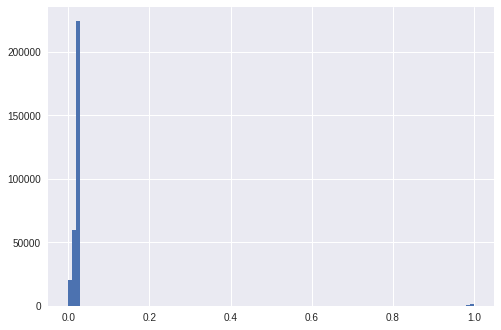

In [70]:
print(len(train_payprice))
train_utility=(300-train_payprice+10000*train_y)/10300
_=plt.hist(train_utility,bins=100)

In [8]:
model = keras.Sequential([
#     keras.layers.Dense(1, input_shape=(n_features,),activation=tf.nn.sigmoid)
    keras.layers.Dense(2000, input_shape=(n_features,),activation=tf.nn.relu),
# #     keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',loss='binary_crossentropy')

n_epochs=100
AUC=[]
survivor=[]
for epoch in range(n_epochs):
  model.fit(train_x,train_y,batch_size=1000,epochs=1,verbose=1)
  validation_p=model.predict(validation_x,verbose=1).squeeze().astype(float)
  AUC.append(roc_auc_score(validation_y, validation_p))
  survivor.append(np.sum(validation_y[np.argsort(validation_p)[-78000:]]))
  print('epoch',epoch+1,'validation set AUC:',AUC[-1], survivor[-1])
  if len(AUC)>1 and AUC[-1]<AUC[-2] and survivor[-1]<survivor[-2]:
    break

303925/303925 [==============================] - 72s 235us/sample
epoch 1 validation set AUC: 0.8529143673545949 161
303925/303925 [==============================] - 65s 214us/sample
epoch 2 validation set AUC: 0.8638102794485452 161
303925/303925 [==============================] - 71s 233us/sample
epoch 3 validation set AUC: 0.872086018125622 161
303925/303925 [==============================] - 75s 246us/sample
epoch 4 validation set AUC: 0.8763429177243738 159
303925/303925 [==============================] - 78s 256us/sample
epoch 5 validation set AUC: 0.8816015035586588 165
303925/303925 [==============================] - 75s 247us/sample
epoch 6 validation set AUC: 0.8720669234079006 161


In [20]:
version_name='new1'
validation_p.tofile('click_predictions/'+'validation_predictions'+version_name+'.bin')  
test_x=np.fromfile(folder+'test_x.bin',dtype=bool).reshape(303375,n_features)
test_p=model.predict(test_x,verbose=1).astype(float)
test_p.tofile('click_predictions/'+'test_predictions'+version_name+'.bin')  

303375/303375 [==============================] - 64s 211us/sample


In [0]:
validation_y=np.fromfile('data2/1751/validation_click.bin',dtype=bool)
validation_payprice=np.fromfile('data2/1751/validation_payprice.bin',dtype=int)
validation_p=np.fromfile('click_predictions/validation_predictions_new0.bin',dtype=float)

# validation_p=np.asarray(pd.read_csv('click_predictions/Luke_xgb_predictor347_maxdepth5_ctr_prediction_valid.csv',header=None)[0])

In [83]:
validation_p

array([0.006875, 0.005028, 0.003462, ..., 0.151123, 0.014386, 0.025298])

In [9]:
bins=15
batch_size=len(validation_y)//bins
validation_y=validation_y[np.argsort(validation_p)]
validation_p=validation_p[np.argsort(validation_p)]
validation_payprice=validation_payprice[np.argsort(validation_p)]
validation_y=validation_y[:bins*batch_size].reshape(bins,batch_size)
validation_p=validation_p[:bins*batch_size].reshape(bins,batch_size)
validation_payprice=validation_payprice[:bins*batch_size].reshape(bins,batch_size)
click=np.flip(np.sum(validation_y,axis=1),axis=0)
cum_click=np.cumsum(np.flip(np.sum(validation_y,axis=1),axis=0))
cpc=np.flip(np.sum(validation_payprice,axis=1)/(np.sum(validation_y,axis=1)*1000),axis=0)

for i in range(bins):
  print('bin',i,i*batch_size,'\t-',(i+1)*batch_size,'\t',click[i],'\t',cum_click[i],'\t',cpc[i])

bin 0 0 	- 20261 	 116 	 116 	 13.71625
bin 1 20261 	- 40522 	 18 	 134 	 88.62955555555556
bin 2 40522 	- 60783 	 10 	 144 	 158.3329
bin 3 60783 	- 81044 	 12 	 156 	 132.04575
bin 4 81044 	- 101305 	 13 	 169 	 122.51946153846154
bin 5 101305 	- 121566 	 7 	 176 	 226.14128571428571
bin 6 121566 	- 141827 	 3 	 179 	 524.8683333333333
bin 7 141827 	- 162088 	 4 	 183 	 396.39875
bin 8 162088 	- 182349 	 2 	 185 	 784.551
bin 9 182349 	- 202610 	 5 	 190 	 315.6996
bin 10 202610 	- 222871 	 2 	 192 	 790.649
bin 11 222871 	- 243132 	 2 	 194 	 801.6095
bin 12 243132 	- 263393 	 2 	 196 	 785.4755
bin 13 263393 	- 283654 	 0 	 196 	 inf
bin 14 283654 	- 303915 	 0 	 196 	 inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


[[303641     82]
 [   153     49]]


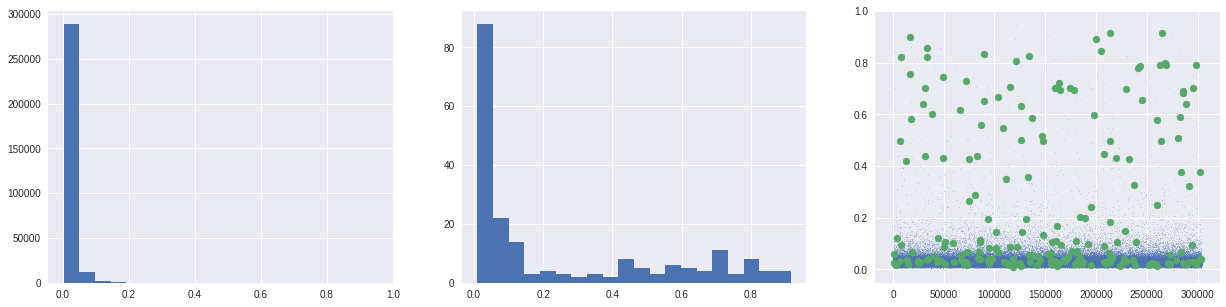

In [73]:
print(confusion_matrix(validation_y,validation_p>0.5))
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(21,5))
_=ax1.hist(validation_p,bins=20)
_=ax2.hist(validation_p[validation_y==1],bins=20)
# _=ax3.set_yscale('log')
_=ax3.scatter(range(len(validation_p)),validation_p,s=0.05)
_=ax3.scatter(np.random.choice(range(len(validation_p)),np.count_nonzero(validation_y==1)),validation_p[validation_y==1])
